# Modeling galaxies in ARES

In [1]:
%matplotlib inline

import ares
import numpy as np
import matplotlib.pyplot as plt

# Preliminaries

Most calculations in ARES involve a model for galaxies in some way. There are several options, which span a pretty wide range in assumptions and complexity, which can often make it difficult to understand (or remember) how to setup calculations and what's really happening under the hood. This notebook is meant to be a pedagogical summary of the different approaches here, including explicit comparisons between the different approaches when possible.

At the moment, there are three qualitatively different ways of modeling galaxies:

1. The `GalaxyAggregate` approach, which does not make any explicit assumptions about individual galaxies or halos, and instead models only the properties of galaxies in aggregate (perhaps with properties that vary as a function of redshift only). 
2. The `GalaxyCohort` approach, which makes the slight generalization that galaxy properties are allowed to depend on halo mass (and optionally redshift), but every galaxy within some halo mass bin is assumed to be the same (perhaps with some scatter).
3. The `GalaxyEnsemble` approach, which makes the final generalization that diversity in galaxy properties within a given halo mass bin is allowed. This is also the only model in which the detailed histories of galaxies can be evolved forward in time, including the synthesis of their spectrum over their past star formation history.

In principle, each kind of population can be used to source reionization or radiation background models, or to make predictions for the observable properties of galaxies (e.g., luminosity functions, colors, etc.). In addition, a given ARES Simulation may involve multiple source populations of different types. More on that later.

There are many quantities that can be computed via simple commands. We (almost) always follow the convention that the methods most often used are named `get_<something>`. Generally the first positional argument is `z` (for the redshift), and for `GalaxyCohort` and `GalaxyEnsemble` we generally have halo mass `Mh` as an additional positional argument. More advanced calculations may require additional keyword arguments. It's also common to have attributes named `tab_<something>` for tabulated quantities (e.g., stellar population synthesis model spectra, halo mass function). Routines that create such lookup tables are called `generate_<something>`. Most of the remaining attributes are binary flags that indicate what kind of source population we're dealing with, e.g., `is_star_forming` and `is_quiescent`, and `is_src_ion` and `is_src_heat`.

To begin, we'll start simple with modeling approach #1, and build more sophisticated models as we go.

# The `GalaxyAggregate` approach

In this section, we'll create the simplest kind of galaxy population in ARES, go over its basic properties, and describe how to build variations of the default version of the model (e.g., user-supplied cosmic star formation histories, spectra, etc.).

To begin with, we'll initialize a population that forms stars in atomic cooling halos with an efficiency of 2% and a BPASS v1 single-star spectrum:

In [2]:
pars_agg = \
{
 # Key assumption #1: star formation is related to collapsed fraction
 'pop_sfr_model': 'fcoll',
 'pop_fstar': 0.02,
 'pop_Tmin': 1e4,
    
 # Key assumption #2: BPASS v1 stellar spectrum (metallicity = 0.004)
 'pop_sed': 'bpass_v1',
 'pop_Z': 0.004,
 'pop_binaries': False,
}

pop_agg = ares.populations.GalaxyPopulation(**pars_agg)

In [3]:
pop_agg.tab_radiative_yield, pop_agg.src.get_rad_yield(0, 100)

# Loaded $ARES/bpass_v1/SEDS/sed.bpass.constant.nocont.sin.z004


(7.293071552167457e+43, 7.293071529822564e+43)

It's worth checking out the methods available by tapping the `tab` key (i.e., `pop_agg.<tab>`). You'll see a lot of `get_<something>` methods, where it's hopefully obvious what that `<something>` means. 

For example, to calculate the cosmic star formation rate density (SFRD), we use the `get_sfrd` function:

# Loaded $ARES/halos/halo_mf_ST_planck_TTTEEE_lowl_lowE_best_logM_1400_4-18_z_1201_0-60.hdf5.


Text(0, 0.5, '$\\rm{SFRD} \\ [M_{\\odot} \\ \\rm{yr}^{-1} \\ \\rm{cMpc}^{-3}]$')

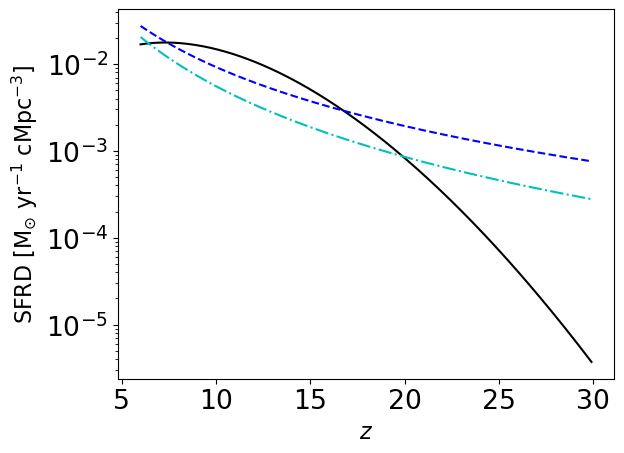

In [4]:
z = np.arange(6, 30, 0.1)
sfrd = pop_agg.get_sfrd(z)
plt.semilogy(z, sfrd, 'k-')

# Compare to Robertson+ 2015, Madau & Dickenson 2014
r15 = ares.data.read('robertson2015')
plt.semilogy(z, r15.get_sfrd(z), 'b--')
m14 = ares.data.read('madau2014')
plt.semilogy(z, m14.get_sfrd(z), 'c-.')

# Make some labels (why not)
plt.xlabel(r'$z$')
plt.ylabel(r'$\rm{SFRD} \ [M_{\odot} \ \rm{yr}^{-1} \ \rm{cMpc}^{-3}]$')

The spectrum of this source population is encoded in the `src` attribute -- an instance of another ARES class defined in `ares.sources`. For SEDs drawn from stellar population synthesis models like BPASS, the raw SED is tabular, and can be accessed via:

(1e+33, 1e+41)

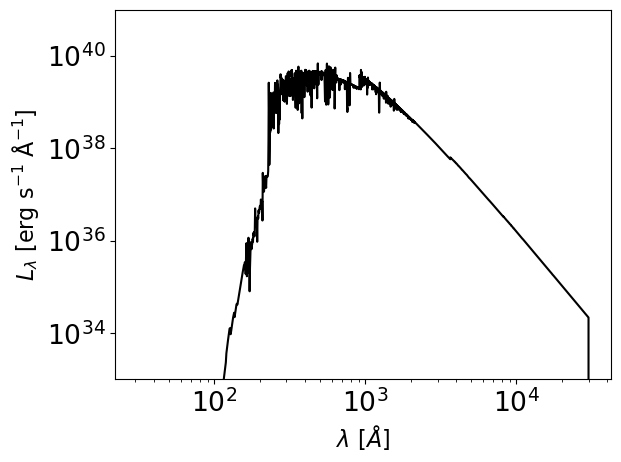

In [5]:
plt.loglog(pop_agg.src.tab_waves_c, pop_agg.src.tab_sed[:,0], 'k-')
plt.xlabel(r'$\lambda \ [\AA]$')
plt.ylabel(r'$L_{\lambda} \ [\rm{erg} \ \rm{s}^{-1} \ \AA^{-1}]$')
plt.ylim(1e33, 1e41)

Both the bin centers (via `tab_waves_c`) and bin edges (via `tab_waves_e`) are available, while the SED itself is 2-dimensional: the second axis corresponds to time. Here, we've just taken the first element, which has a corresponding time (in Myr) of:

In [6]:
pop_agg.src.tab_t[0]

1.0

Many SED options in ARES are *not* tabular in nature, and are instead parameterized as smooth functions. In those cases, the normalization of the spectrum is left to the user (via `pop_radiative_yield` in the `(pop_EminNorm, pop_EmaxNorm)` band. More on that later.

Let's look at the volume-averaged emissivity, i.e., the integral over the emissions of the entire population. In this case, because we are neglecting variations in galaxy properties with halo mass and redshift, the emissivity will be exactly equivalent to the product of the cosmic SFRD and the luminosity per unit star formation.

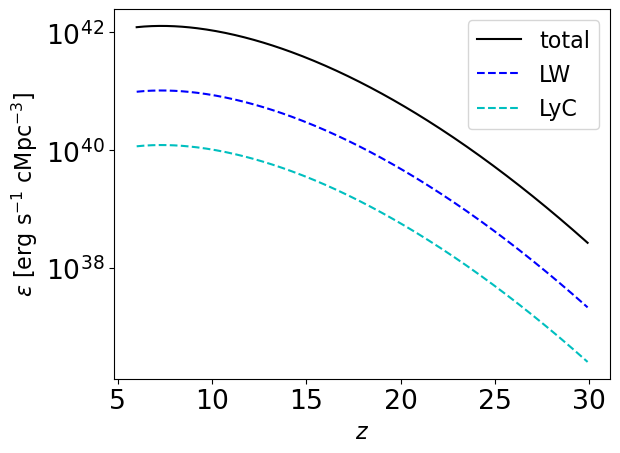

In [7]:
plt.semilogy(z, pop_agg.get_emissivity(z), 'k-', label='total')
plt.semilogy(z, pop_agg.get_emissivity(z, Emin=11.2, Emax=13.6), 'b--', label='LW')
plt.semilogy(z, pop_agg.get_emissivity(z, Emin=13.6, Emax=np.inf), 'c--', label='LyC')
plt.xlabel(r'$z$')
plt.ylabel(r'$\epsilon \ [\rm{erg} \ \rm{s}^{-1} \ \rm{cMpc}^{-3}]$')
plt.legend()

Can also look at the emissivity in terms of photon number:

/Users/jmirocha/Work/mods/ares/ares/sources/Source.py:433: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  final = quad(i1, Emin, Emax, points=self.sharp_points)[0] \
/Users/jmirocha/Work/mods/ares/ares/sources/Source.py:434: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and call

ValueError: Infinity inputs cannot be used with break points.

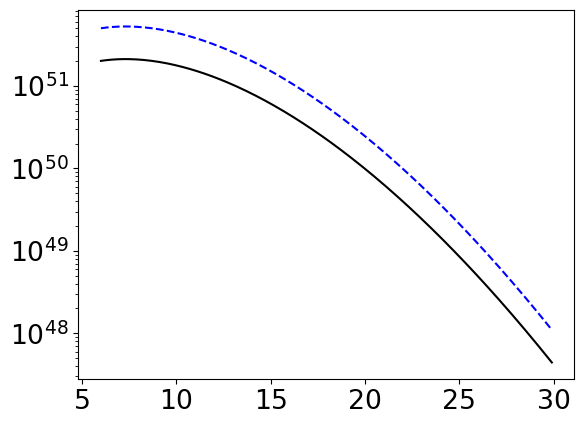

In [8]:
plt.semilogy(z, pop_agg.get_photon_emissivity(z), 'k-', label='total')
plt.semilogy(z, pop_agg.get_photon_emissivity(z, Emin=11.2, Emax=13.6), 'b--', label='LW')
plt.semilogy(z, pop_agg.get_photon_emissivity(z, Emin=13.6, Emax=np.inf), 'c--', label='LyC')
plt.xlabel(r'$z$')
plt.ylabel(r'$\epsilon \ [\rm{photons} \ \rm{s}^{-1} \ \rm{cMpc}^{-3}]$')
plt.legend()

Plot full emissivity (vs. wavelength) at a few zs.

# The `GalaxyCohort` approach

Next, we'll explore models with mass-dependent galaxy properties. This was designed with the high-z Universe in mind ($z \gtrsim 4$) but can be generalized to model galaxies at any redshift. There are a few ways to do this:

1. By default, ARES assumes that the star formation rate of galaxies is proportional to the mass accretion rate of DM halos, 

\begin{equation}
\dot{M}_{\ast} = f_{\ast} \left(\frac{\Omega_{b,0}}{\Omega_{m,0}} \right) \dot{M}_h
\end{equation}

In principle one can integrate these star formation histories to obtain stellar masses self-consistently, but if interested only in rest-UV LFs, this is all you need. We'll discuss different models for $\dot{M}_h$ in a moment.

2. The MAR-based approach in #1 is well-suited to the high-z Universe, where we have models for the MAR that seem to work pretty well. However, to bypass this approach for applications at lower redshift (or just for fun), we can instead provide models for the stellar masses and star formation rates of galaxies separately.

## Models based on the mass accretion rate of DM halos

It is common to model the star formation efficiency of galaxies as a double power-law in halo mass, 

\begin{equation}
f_{\ast}(M_h) = \frac{2 f_{\ast,p}} {\left(\frac{M_h}{M_{\text{p}}} \right)^{\gamma_{\text{lo}}} + \left(\frac{M_h}{M_{\text{p}}}  \right)^{\gamma_{\text{hi}}}}
\end{equation}

where the free parameters are the normalization, $f_{\ast,p}$, the peak mass, $M_p$, and the power-law indices in the low-mass and high-mass limits, $\gamma_{\text{lo}}$ and $\gamma_{\text{hi}}$, respectively. Combined with a model for the mass accretion rate onto dark matter halos ($\dot{M}_h$; see next section), the star formation rate is fully specified.




In [ ]:
pars_hod = \
{
 'pop_sfr_model': 'sfe-func',
 'pop_sed': 'bpass_v1',
 'pop_Z': 0.004,
    
 'pop_fstar': 'pq[0]',
 'pq_func[0]': 'dpl',
 'pq_func_var[0]': 'Mh',

 'pq_func_par0[0]': 0.05,       
 'pq_func_par1[0]': 2.8e11,
 'pq_func_par2[0]': 0.49,
 'pq_func_par3[0]': -0.61, 
 'pq_func_par4[0]': 1e10,    
}

pop_hod = ares.populations.GalaxyPopulation(**pars_hod)

In [ ]:
sfr = pop_hod.get_sfr(z=6, Mh=pop_hod.halos.tab_M)
mar = pop_hod.get_mar(z=6, Mh=pop_hod.halos.tab_M)
plt.loglog(pop_hod.halos.tab_M, sfr, 'k-', label='SFR')
plt.loglog(pop_hod.halos.tab_M, mar, 'b-', label='MAR')
plt.xlabel(r'$M_h/M_{\odot}$')
plt.ylabel(r'SFR,MAR $[M_{\odot} \ \rm{yr}^{-1}]$')
plt.legend()

In [ ]:
mags = np.linspace(-24, -10)
bins, lf = pop_hod.get_lf(6, mags)
plt.semilogy(mags, lf)

In general, the SFE curve must be calibrated to an observational dataset (see [Fitting to UVLFs](example_mcmc_lf)), but you can also just grab our best-fitting parameters for a redshift-independent SFE curve. For example, the results from [Mirocha, Furlanetto, & Sun (2017)](http://adsabs.harvard.edu/abs/2017MNRAS.464.1365M>) are kept in a ``ParameterBundle`` as 

In [ ]:
pars_m17 = ares.util.ParameterBundle('mirocha2017:base')

In [ ]:
# Mimic Mh-independent star formation efficiency
pars_hod_flat = pars_hod.copy()
pars_hod_flat['pq_func_par0[0]'] = 0.02
pars_hod_flat['pq_func_par2[0]'] = 0
pars_hod_flat['pq_func_par3[0]'] = 0


pop_hod_flat = ares.populations.GalaxyPopulation(**pars_hod_flat)

plt.semilogy(z, pop_agg.get_sfrd(z), 'k-', label='fcoll-based')
plt.semilogy(z, pop_hod_flat.get_sfrd(z), 'b--', label='MAR-based')
plt.xlabel(r'$z$')
plt.ylabel(r'$\rm{SFRD} \ [M_{\odot} \ \rm{yr}^{-1} \ \rm{cMpc}^{-3}]$')
plt.legend()

In [ ]:
plt.semilogy(z, pop_agg.get_emissivity(z), 'k-')
plt.semilogy(z, pop_hod_flat.get_emissivity(z), 'b--')

## Models based on the stellar-mass-halo-mass relation and star-forming main sequence

As alluded to previously, one can also separately parameterize the relationship between stellar mass and halo mass, and star formation rate and stellar mass...

In [ ]:
pars_hod = \
{
 'pop_sfr_model': 'smhm-func',
 
 # SMHM parameters
 'pop_fstar': 'pq[0]',
 'pq_func[1]': 'dpl_evolN',
 'pq_func_par0[0]': 3e-4,
 'pq_func_par1[0]': 1.5e12,
 'pq_func_par2[0]': 1.0,
 'pq_func_par3[0]': -0.4,
 'pq_func_par6[0]': 0.0,   # norm
 'pq_func_par7[0]': 0.0,   # Mp
 'pq_func_par8[0]': 0.0,   # Only use if slopes evolve, e.g., in dplp_evolNPS
 'pq_func_par9[0]': 0.0,   # Only use if slopes evolve, e.g., in dplp_evolNPS

 # sSFR(z, Mstell)
 'pop_ssfr': 'pq[1]',
 'pq_func[1]': 'dpl_evolN',
 'pq_func_var[1]': 'Ms',
 'pq_func_var2[1]': '1+z',
 'pq_func_par0[1]': 3e-10,
 'pq_func_par1[1]': 5e9,
 'pq_func_par2[1]': 0.0,
 'pq_func_par3[1]': -0.7,
 'pq_func_par4[1]': 1e9,
 'pq_func_par5[1]': 1.,
 'pq_func_par6[1]': 2.,

 'final_redshift': 0, # Make this default?
 'halo_dt': None,
 'halo_tmax': None,
 'halo_zmin': 0,
 'cosmology_id': 'best',
 'cosmology_name': 'planck_TTTEEE_lowl_lowE',

}

pop_hod = ares.populations.GalaxyPopulation(**pars_hod)

# The `GalaxyEnsemble` approach


# Working with multiple, connected galaxy populations

Often, we'll want to run calculations with multiple source populations, e.g., we want to model the reionization *and* re-heating of the high redshift IGM. It's common to link X-ray production to star formation, so when we create a new population of X-ray sources we can set things up to avoid re-computing the star formation history.

In [ ]:
pars_agg = ares.util.ParameterBundle(**pars_agg)
pars_agg.num = 0

In [ ]:
pars_agg_x = \
{
 'pop_sfr_model{1}': 'link:sfrd:0',
 
 'pop_sed{1}': 'pl',
 'pop_rad_yield{1}': 2.6e39,
 'pop_alpha{1}': -1.5,
 'pop_logN{1}': 21,
    
    
 'pop_EminNorm{1}': 500,
 'pop_EmaxNorm{1}': 8e3,
 'pop_Emin{1}': 200,
 'pop_Emax{1}': 3e4,
    
 # etc
}

pars_agg_x = ares.util.ParameterBundle(**pars_agg_x)

pars_agg_2pop = pars_agg + pars_agg_x

In [ ]:
sim = ares.simulations.Simulation(**pars_agg_2pop)

First, let's verify that both populations have the same SFRD:

Now, let's show the emissivity...